<a href="https://colab.research.google.com/github/EleonoraBartolomucci/Fairness/blob/master/exposure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests
from lxml import html
import pandas as pd
import json
import csv
import numpy as np
import os
import pickle
import random
import math
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
business_headers = ['index', 'business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# DOWNLOAD user.json FROM DRIVE
users_dataset_id = '1JokoV68YD5Iq2l4Y_IV2RJzBpD_mSCyq'  # FILE ID, got on google drive with condivision link
download = drive.CreateFile({'id': users_dataset_id})
download.GetContentFile('user.json')

In [0]:
# DOWNLOAD business.json FROM DRIVE
business_dataset_id = '1Qoy132gb205xAIFjkBbZ2CyYDeaz9yqU'  # FILE ID, got on google drive with condivision link
download = drive.CreateFile({'id': business_dataset_id})
download.GetContentFile('business.json')

In [0]:
# DOWNLOAD review.json FROM DRIVE
review_dataset_id = '1mW1WbpMFjN0qQpLnM-R_TzNpAkFsBLHQ'  # FILE ID, got on google drive with condivision link
download = drive.CreateFile({'id': review_dataset_id})
download.GetContentFile('review.json')

In [0]:
# READ JSON
def read_json(json_path):
  data = []
  with open(json_path, "r") as my_file: 
    for line in my_file:
      line_json = json.loads(line)
      data.append(line_json)
  return data


# PARSE JSON IN CSV
def json2csv(csv_path, json_path):
  data = read_json(json_path)
  df = pd.DataFrame(data)
  df.to_csv(csv_path)

In [0]:
users = read_json('user.json')
users = pd.DataFrame(users)
business = read_json('business.json')
business = pd.DataFrame(business)
reviews = read_json('review.json')
reviews = pd.DataFrame(reviews)

FileNotFoundError: ignored

In [0]:
def statistics(users, reviews, business):
  res = pd.DataFrame()
  cont = 0
  prec_user_id = '0'

  for i, user in users.iterrows():
    if cont == 1000:
      break
    user_id = user['user_id']  # 4, 9, 16, 21!, 22!, 23, 24
    # Get all reviews of one user
    # 'https://www.yelp.com/user_details_reviews_self?userid=NQffx45eJaeqhFcMadKUQA&rec_pagestart=90'??? no
    user_reviews = reviews[reviews['user_id'] == user_id]
    # Get all restaurants
    business_ids = user_reviews[['business_id']]
    result = business_ids.merge(business)
    is_restaurant = result['categories'].str.contains('Restaurants', regex=False, na=False)
    user_restaurant_reviews = result[is_restaurant]
    user_restaurant_reviews['user_id'] = user_id
    #user_restaurant_reviews.to_csv('user_restaurant_reviews' + str(cont) + '.csv')
    res = res.append(user_restaurant_reviews.groupby(['user_id', 'state'])['user_id'].count().reset_index(name="review_count"))
    if (user_id != prec_user_id) and not user_restaurant_reviews.empty:
      cont = cont + 1
    # print(res)
    prec_user_id = user_id

  res.to_csv('result.csv')  # PRINT THE state OF EACH user FOR HIS RESTAURANT reviews


In [0]:
### UNIQUE VALUE OF state, city AND categories OF BUSINESS
# To filter only RESTAURANTS
# is_restaurant = business['categories'].str.contains('Restaurants', regex=False, na=False)
# restaurants = business[is_restaurant]

print('UNIQUE VALUE OF \'state\' ATTRIBUTE IN RESTAURANTS = ', business['state'].nunique())
print('UNIQUE VALUE OF \'city\' ATTRIBUTE IN RESTAURANTS = ', business['city'].nunique())
df_cat = business[['categories']]
distinct_categories_list = []
for index, row in df_cat.iterrows():
  if row['categories'] != None:
    lst = [item.strip() for item in row['categories'].split(',')]
    distinct_categories_list = list(set(distinct_categories_list + lst))
print('UNIQUE VALUE OF \'categories\' ATTRIBUTE distinct values ', len(distinct_categories_list))

UNIQUE VALUE OF 'state' ATTRIBUTE IN RESTAURANTS =  36
UNIQUE VALUE OF 'city' ATTRIBUTE IN RESTAURANTS =  1204
UNIQUE VALUE OF 'categories' ATTRIBUTE distinct values  1300


In [0]:
def divide_business_by_review_count():
  data = read_json('business.json')
  df = pd.DataFrame(data)
  max = df['review_count'].max()
  min = df['review_count'].min()
  print('max is = ', max)
  print('min is = ', min)
  median = (max-min)/2  # 4172,5
  business_with_few_review_count = df[df['review_count']<median]

  # print(business_with_few_review_count)

  business_with_many_review_count = df[df['review_count']>=median]

  # print(business_with_many_review_count)
  business_with_few_review_count.to_csv('few_review_business.csv')
  business_with_many_review_count.to_csv(r'many_review_business.csv')
  return (business_with_few_review_count, business_with_many_review_count)

In [0]:
def get_ranking_from_call(url_business, lang, sort, query, is_random):
  
  headers = [{"name":"Accept","value":"*/*"},{"name":"Accept-Encoding","value":"gzip, deflate, br"},{"name":"Accept-Language","value":"it-IT,it;q=0.8,en-US;q=0.5,en;q=0.3"},{"name":"Connection","value":"keep-alive"},{"name":"Content-Type","value":"application/x-www-form-urlencoded; charset=utf-8"},{"name":"Cookie","value":"qntcst=D; hl=en_US; wdi=1|3C26116D69138F61|0x1.78d019f71a444p+30|a7756ff94751d3a9; _ga=GA1.2.3C26116D69138F61; location=%7B%22city%22%3A+%22New+York%22%2C+%22state%22%3A+%22NY%22%2C+%22country%22%3A+%22US%22%2C+%22latitude%22%3A+40.713%2C+%22longitude%22%3A+-74.0072%2C+%22max_latitude%22%3A+40.8523%2C+%22min_latitude%22%3A+40.5597%2C+%22max_longitude%22%3A+-73.7938%2C+%22min_longitude%22%3A+-74.1948%2C+%22zip%22%3A+%22%22%2C+%22address1%22%3A+%22%22%2C+%22address2%22%3A+%22%22%2C+%22address3%22%3A+null%2C+%22neighborhood%22%3A+null%2C+%22borough%22%3A+null%2C+%22provenance%22%3A+%22YELP_GEOCODING_ENGINE%22%2C+%22display%22%3A+%22New+York%2C+NY%22%2C+%22unformatted%22%3A+%22New+York%2C+NY%2C+US%22%2C+%22accuracy%22%3A+4.0%2C+%22language%22%3A+null%7D; xcj=1|Ptt9P03gfc75x_PBT9zmqCkUuSuyB7PR-wWUBvABNi4; __qca=P0-60561249-1581956668708; G_ENABLED_IDPS=google; __cfduid=db8764ff59d8028a6c2e1b214867927d81583160194; _gid=GA1.2.2014867238.1583835527; bse=05dcd9d5de304ef0b1d9a76fa768b10f; sc=8a1ca0dbc2; pid=505721aa4569e7bb"},{"name":"Host","value":"www.yelp.com"},{"name":"Referer","value":"https://www.yelp.com/biz/noche-de-margaritas-new-york"},{"name":"TE","value":"Trailers"},{"name":"User-Agent","value":"Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:73.0) Gecko/20100101 Firefox/73.0"},{"name":"X-Requested-By-React","value":"true"},{"name":"X-Requested-With","value":"XMLHttpRequest"}]
  headers_ok = {}
  for header in headers:
    temp = {
        header['name']: header['value']
    }
    headers_ok.update(temp)
  
  x = 0
  reviews_list = []
  position = 1
  url = url_business + "/review_feed?rl=" + lang + "&sort_by=" + sort + "&q=" + query
  
  while 1:
    if x == 0:
      page_load = requests.get(url + '&start=', headers=headers_ok)
    else:
      page_load = requests.get(url + '&start=' + str(x), headers=headers_ok)
    print(page_load)
    x = x + 20
    reviews = page_load.json()['reviews']
    # print(json.dumps(reviews, indent=4, sort_keys=True))
    if not reviews:
      break
    if is_random:
      # shuffle the reviews
      random.shuffle(reviews)
    for review in reviews:
      reviews_list.append((position, review['userId'], review['user']['reviewCount']))
      position = position + 1
  print(reviews_list)
  return reviews_list


In [24]:
############################# EXECUTE IN LOCAL (if not blocked by yelp) #############################################
def download_ranking_by_relevance(business_id):
  random = False
  ranking = get_ranking_from_call("https://www.yelp.com/biz/" + business_id, "en", "relevance_desc", "", random)
  print(ranking)
  with open("ranking_by_relevance.txt", "wb") as fp:   #Pickling
    pickle.dump(ranking, fp)
  ### TODO: if executed in local, then UPLOAD ranking_by_relevance.txt ON COLAB 


def download_ranking_by_date(business_id):
  random = False
  ranking = get_ranking_from_call("https://www.yelp.com/biz/" + business_id, "en", "date_desc", "", random)
  print(len(ranking))
  with open("ranking_by_date.txt", "wb") as fp:   #Pickling
    pickle.dump(ranking, fp)
  ### TODO: if executed in local, then UPLOAD ranking_by_date.txt ON COLAB 


def download_ranking_by_random(business_id):
  random = True
  ranking = get_ranking_from_call("https://www.yelp.com/biz/" + business_id, "en", "relevance_desc", "", random)
  print(len(ranking))
  with open("ranking_by_random.txt", "wb") as fp:   #Pickling
    pickle.dump(ranking, fp)
  ### TODO: if executed in local, then UPLOAD ranking_by_random.txt ON COLAB


download_ranking_by_relevance('gnKjwL_1w79qoiV3IC_xQQ')

<Response [503]>


JSONDecodeError: ignored

In [0]:
def download_rankings(business_id):
  # Business URL: 'https://www.yelp.com/biz/noche-de-margaritas-new-york'
  download_ranking_by_relevance(business_id)
  download_ranking_by_date(business_id)
  download_ranking_by_random(business_id)

max is =  8348
min is =  3
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
[(1, 'yoF8kxQTH4qCDijyKMm1KA', 75), (2, 'T2UB7Fo27fzD-9EYGUyBhA', 97), (3, 'qjYXOBnladFYhciGBSgAMw', 719), (4, 'mCrhj_CG3_pOmDFcfKotRQ', 307), (5, 'oXCw9ETEIWFkc31es916AQ', 1), (6, 'HFFiM63x9asevqVOZG5GBQ', 474), (7, 'rYlHp6XpdtybhkoU07odgg', 59), (8, 'VcNqxeNiiWDa4Lj0VklaVw', 62), (9, 'PDwBN2Yjh2P4qgbgM6Jqtg', 143), (10, 'chZwdGspJz5_xmm9dQnBkQ', 153), (11, 'JzAZClzh-YS0lifbDYnavQ', 122), (12, 'lpcYAvuU6ljcJ7jtFUE_Tg', 98), (13, 'ZwyiHqgk2ZyUAI-U4Jcl0w', 14), (14, 'GImky9qL4PnlLM9Iq_pWMA', 14), (15, 'sbbB6Y4yIZIInvt0LFYYew', 83), (16, 'bRyTHS0CsHC4f1WDaRpjwA', 28), (17, 'LOkEzqQvXSkhnU_IUei1hg', 4), (18, 'xDl9ZF3SckkZde_48W6WeA', 1125), (19, 'UEWMagmCWKqR1kzm4CeoMQ', 21), (20, 'Gd1yhzbSXLs2OKVS5lGaDA', 122), (21, 'yqVH6srXMhhJ4GroDNF4Qg', 26), (22, 'FyikYazQbNoOumDooOQyyA', 

JSONDecodeError: ignored

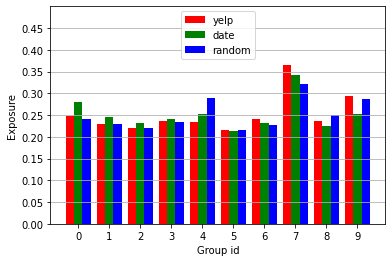

In [23]:
few_revcount, many_revcount = divide_business_by_review_count()
business_temp_ids = [few_revcount['business_id'].iloc[2], many_revcount['business_id'].iloc[1]]
for business_id in business_temp_ids:
  attribute = 'Review_Count'
  download_rankings(business_id)
  df_ranking_by_relevance, df_ranking_by_date, df_ranking_by_random = pipeline1()
  group_list = pipeline2(attribute, df_ranking_by_relevance, df_ranking_by_date, df_ranking_by_random)
  pipeline3(attribute, group_list, df_ranking_by_relevance, df_ranking_by_date, df_ranking_by_random)

In [0]:
def pipeline1():
  ############################# EXECUTE ON COLAB #############################################
  ### READ THE RANKING FROM FILE
  with open("ranking_by_relevance.txt", "rb") as fp:   # Unpickling
    ranking_by_relevance = pickle.load(fp)
  ###
  ### READ THE RANKING FROM FILE
  with open("ranking_by_date.txt", "rb") as fp:   # Unpickling
    ranking_by_date = pickle.load(fp)
  ###
  ### READ THE RANKING FROM FILE
  with open("ranking_by_random.txt", "rb") as fp:   # Unpickling
    ranking_by_random = pickle.load(fp)
  ###

  # df_ranking = find_users_in_dataset(ranking)  # cannot find all users

  df_ranking_by_relevance = create_df_users(ranking_by_relevance)
  df_ranking_by_date = create_df_users(ranking_by_date)
  df_ranking_by_random = create_df_users(ranking_by_random)
  
  print("\n++++++++++++++++ RANKING ++++++++++++++++++\n")

  print("Ranking by Yelp filter:")
  print(df_ranking_by_relevance)
  print('\n')
  print("Ranking by Date:")
  print(df_ranking_by_date)
  print('\n')
  print("Ranking Random:")
  print(df_ranking_by_random)
  print('\n')

  return df_ranking_by_relevance, df_ranking_by_date, df_ranking_by_random


def pipeline2(attribute, df_ranking_by_relevance, df_ranking_by_date, df_ranking_by_random):
  print("\n++++++++++++++++ GROUPS CREATION ++++++++++++++++++\n")
  print("ATTRIBUTE: " + attribute + "\n")
  group_list = create_objective_groups_by_percentile(df_ranking_by_relevance, attribute, 10) # number of groups to be created
  # group_list = create_objective_groups_by_size(df_ranking_by_relevance, attribute, 10)
  index = 1
  for group in group_list:
      print("\nGROUP " + str(index) + ":")
      for person in group:
          print(person['user_id'] + ", " + str(person['Review_Count']))
      index = index + 1
  return group_list


def pipeline3(attribute, group_list, df_ranking_by_relevance, df_ranking_by_date, df_ranking_by_random):
  print("\n++++++++++++++++ EXPOSURE CALCULATION ++++++++++++++++++\n")
  print("------------Ranking by Yelp filter:------------")
  index = 0
  yelp_exposures = []
  for group in group_list:
      current_exp = exposure(group, df_ranking_by_relevance)
      yelp_exposures.append((index, current_exp))
      print("\nEXPOSURE of group " + str(index) + " is: " + str(current_exp))
      index = index + 1
  print('\n')
  print("------------Ranking by Date:------------")
  index = 0
  date_exposures = []
  for group in group_list:
      current_exp = exposure(group, df_ranking_by_date)
      date_exposures.append((index, current_exp))
      print("\nEXPOSURE of group " + str(index) + " is: " + str(current_exp))
      index = index + 1
  print('\n')
  print("------------Ranking Random:------------")
  index = 0
  random_exposures = []
  for group in group_list:
      current_exp = exposure(group, df_ranking_by_random)
      random_exposures.append((index, current_exp))
      print("\nEXPOSURE of group " + str(index) + " is: " + str(current_exp))
      index = index + 1
  print('\n')

  get_plots(yelp_exposures, date_exposures, random_exposures, 'plot_'+attribute+'_'+business_id)



In [0]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

def get_plots(yelp_exposures, date_exposures, random_exposures, title):
  width = 0.27
  y_min = 0.0
  y_max = 0.5

  x1 = [el[0] - width for el in yelp_exposures]
  x2 = [el[0] for el in date_exposures]
  x3 = [el[0] + width for el in random_exposures]

  y1 = [el[1] for el in yelp_exposures]
  y2 = [el[1] for el in date_exposures]
  y3 = [el[1] for el in random_exposures]

  plt.bar(x1,y1,width=width,align='center', color='red', label='yelp')
  plt.bar(x2,y2,width=width,align='center', color='green', label='date')
  plt.bar(x3,y3,width=width,align='center', color='blue', label='random')
  plt.legend(loc="upper center")
  plt.xlabel('Group id')
  plt.ylabel('Exposure')
  plt.xticks(np.arange(min(x2), max(x2)+1, 1.0))
  plt.yticks(np.arange(y_min, y_max, 0.05))
  axes = plt.gca()
  axes.set_ylim([y_min,y_max])
  axes.yaxis.grid()

  #plt.show()
  plt.savefig(title + '.png')

In [0]:
def create_df_users(ranking):
  df_ranking = pd.DataFrame(ranking, columns=['Position', 'user_id', 'Review_Count']).sort_values('Position')
  return df_ranking

In [0]:
def create_objective_groups_by_percentile(df_users, attribute, N_of_groups):
  # order df_users by review_count
  df_users = df_users.sort_values(attribute).reset_index(drop=True)
  group_list = []
  percentile_up_value = math.ceil(100/N_of_groups)
  percentile_down_value = int(100/N_of_groups)
  initial_percentile_value = percentile_down_value
  array_of_values = df_users[attribute].tolist()
  index = 0
  prec_max_value = -1
  while percentile_up_value <= 100 or percentile_down_value <= 100:
    group_list.append([])
    if percentile_up_value > 100:
      percentile_up_value = 100
    max_value_in_group = np.percentile(array_of_values, percentile_up_value)
    for i, user in df_users.iterrows():
      if user[attribute] <= max_value_in_group and user[attribute] > prec_max_value:
        group_list[index].append(user)
    index = index + 1
    percentile_up_value = percentile_up_value + initial_percentile_value
    percentile_down_value = percentile_down_value + initial_percentile_value
    prec_max_value = max_value_in_group

  return group_list


In [0]:
def exposure(group, ranking):
    return sommatory(group, ranking)/(len(group))


def sommatory(group, ranking):  # ranking is a list of user_id
    sum = 0
    for user in group:
        user_id = user['user_id']
        position = ranking.loc[ranking['user_id'] == user_id, 'Position'].tolist()[0]
        # position = ranking.index[ranking['user_id'] == user_id].tolist()[0]
        # position = position + 1
        sum = sum + exp(position)
    return sum


def exp(position):
    if position == 'no match':
        return 0
    else:
        return 1/np.log(1 + position)


def demographic_parity(g1, g2, s):
    ex1 = exposure(g1, s)
    ex2 = exposure(g2, s)
    print("|" + str(ex1) + " - " + str(ex2) + "| < 0.1?")
    return np.absolute(ex1 - ex2) < 0.1  # in our case, g1 and g2 are groups of author (reviewer)


def app(author, df):
    return df[df['UserId'] == author].iloc[0, -1]


In [0]:
def create_objective_groups_by_size(df_users, attribute, range):
    # order df_users by review_count
    df_users = df_users.sort_values(attribute).reset_index(drop=True)
    group_list = [[]]
    i = 0
    group_index = 0
    prec = -1
    for index, user in df_users.iterrows():
        if i == range:
            i = 0
            group_list.append([])
            group_index = group_index + 1
        temp = user[attribute]
        if temp != prec:
            prec = temp
            i = i + 1
        group_list[group_index].append(user)
    print("Number of groups created: " + str(group_index+1))
    return group_list


In [0]:
# TODO: get review_count from web page
def get_ranking(url):

  i=1
  reviews_text = []
  reviews_date = []
  reviews_userid = []
  x=0

  while 1:
    if x == 0:
      page_content = requests.get(url)
    else:
        page_content = requests.get(url + '?start=' + str(x))
    x = x + 20
    
    tree = html.fromstring(page_content.content)
    recommended_reviews_text = "Recommended Reviews"
    reviews_list = tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/*' % recommended_reviews_text)
    if not reviews_list:
      break
    else:
      # Index for ranking
      j=1
      for review in reviews_list:
          reviews_text.append((i, tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/li[%d]/div/div[last()]/div[p]/p/span' % (recommended_reviews_text, j))[0].text))
          reviews_date.append((i, tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/li[%d]/div/div[last()]/div[1]/div/div[2]/span' % (recommended_reviews_text, j))[0].text))
          user_link = tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/li[%d]/div/div/div/div/div/div/div/a/@href' % (recommended_reviews_text, j))[0]
          reviews_userid.append((i,user_link[user_link.find('=')+1:]))
          i = i + 1
          j = j + 1


  print(reviews_text)
  print("N. of reviews = " + str(len(reviews_text)))
  print(reviews_date)
  print("N. of reviews = " + str(len(reviews_date)))
  print(reviews_userid)
  print("N. of reviews = " + str(len(reviews_userid)))
  return reviews_userid


In [0]:
def find_users_in_dataset(users):
    data = []
    with open("user.json", 'r') as file:
        for line in file:
            json_data = json.loads(line)
            data.append(json_data)
    df = pd.DataFrame(data)
    df_ranking = pd.DataFrame(users, columns=['Position', 'user_id'])
    df_merged = df_ranking.merge(df, on='user_id')
    # temp = df[df['user_id'].isin(users)]
    return df_merged


def exists_in_dataset(userid):
  found = False
  with open("user.json", 'r') as file:
        for line in file:
            json_data = json.loads(line)
            if json_data['user_id'] == userid:
              found = True
  if found:
    print("Trovato")
  else:
    print("Non trovato")
  return found


def find_users_in_chopped_dataset(users):
    found = False
    data = []
    i = 1
    j = 100000
    df_users = pd.DataFrame()
    while not found:
        path = "user" + str(i) + "-" + str(j) + ".json"
        try:
            with open(path, 'r') as file:
                for line in file:
                    json_data = json.loads(line)
                    data.append(json_data)
            df = pd.DataFrame(data)
        except FileNotFoundError:
            print("Cannot find all users into the dataset")
            return 0
        else:
            temp = df[df['user_id'].isin(users)]  # df of users of the ranking
            df_users = df_users.append(temp)
            if df_users.shape[0] == len(users):
                found = True
            else:
                i = i + 100000
                j = j + 100000
    return df_users
